# Steps to extract, format, and pickle the data

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
import csv
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
def maybe_extract(filename, num_files, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data = []
  for i in range(1,num_files+1):
        data.append(str(i)+'.png')
  data = [
    os.path.join(root, d) for d in data
    if os.path.isfile(os.path.join(root, d))]
  print(len(data))
  return data
  
train_folders = maybe_extract('train.tar.gz', 33402)
test_folders = maybe_extract('test.tar.gz', 13068)
valid_folders = maybe_extract('extra.tar.gz',10000)

train already present - Skipping extraction of train.tar.gz.
33402
test already present - Skipping extraction of test.tar.gz.
13068
extra already present - Skipping extraction of extra.tar.gz.
10000


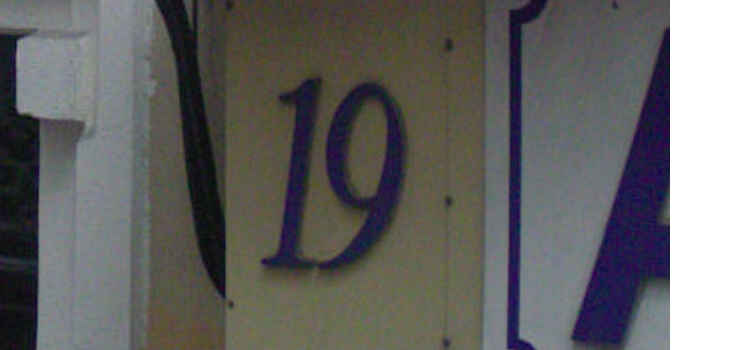

In [5]:
image_file = train_folders[0]
display(Image(image_file))

In [7]:
train_bbox = []
num_rows = 73258

with open('digitStruct_train.csv', 'rb') as csvfile:
    x = csv.reader(csvfile, delimiter=',')
    x.next()
    row = x.next()
    bbox_left = int(row[2])
    bbox_top = int(row[3])
    bbox_width = int(row[4])
    bbox_height = int(row[5])
    
    for _ in range(num_rows - x.line_num):
        next_row = x.next()
        if row[0] == next_row[0]:
            if int(next_row[2]) < bbox_left:
                bbox_left = int(next_row[2])
            if int(next_row[3]) < bbox_top:
                bbox_top = int(next_row[3])
            bbox_width += int(next_row[4])
            if bbox_height < int(next_row[5]):
                bbox_heigth = int(next_row[5])
        else:
            train_bbox.append([bbox_left,bbox_top,bbox_width,bbox_height])
            row = next_row
            bbox_left = int(row[2])
            bbox_top = int(row[3])
            bbox_width = int(row[4])
            bbox_height = int(row[5])
    
    train_bbox.append([bbox_left,bbox_top,bbox_width,bbox_height]) 

print(len(train_bbox))

33402


(83, 199, 3)


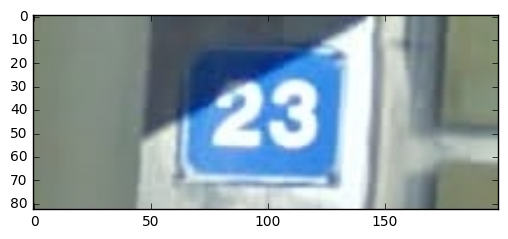

[0.24096385542168675, 0.7590361445783133, 0.30954773869346736, 0.678391959798995]


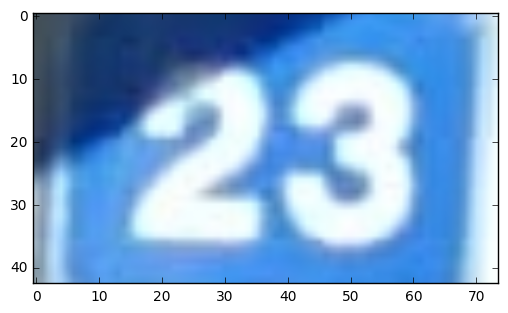

In [8]:
i = 1
image_data = ndimage.imread(train_folders[i])
print(image_data.shape)
plt.imshow(image_data)
plt.show()

offset_height = train_bbox[i][1]*0.8 / float(image_data.shape[0])
target_height = (train_bbox[i][1] + int(train_bbox[i][3]*1.2)) / float(image_data.shape[0])
offset_width = train_bbox[i][0]*0.8 / float(image_data.shape[1])
target_width = (train_bbox[i][0] + int(train_bbox[i][2]*1.2)) / float(image_data.shape[1])
print([offset_height, target_height, offset_width, target_width])

cropped_image = image_data[int(offset_height*image_data.shape[0]):int(target_height*image_data.shape[0]),
                           int(offset_width*image_data.shape[1]):int(target_width*image_data.shape[1])]
plt.imshow(cropped_image)
plt.show()

In [10]:
training_bbox = []
for i in range(len(train_bbox)):
    image_data = ndimage.imread(train_folders[i])
    offset_height = train_bbox[i][1]*0.8 / float(image_data.shape[0])
    target_height = (train_bbox[i][1] + int(train_bbox[i][3]*1.2)) / float(image_data.shape[0])
    offset_width = train_bbox[i][0]*0.8 / float(image_data.shape[1])
    target_width = (train_bbox[i][0] + int(train_bbox[i][2]*1.2)) / float(image_data.shape[1])
    training_bbox.append([offset_height, target_height, offset_width, target_width])
print(len(training_bbox))

33402


[0.24096385542168675, 0.7590361445783133, 0.30954773869346736, 0.678391959798995]


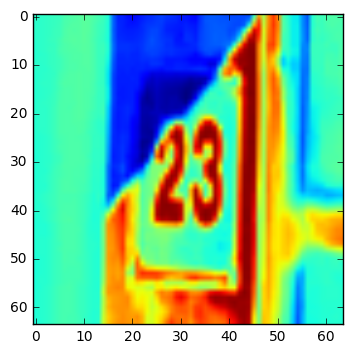

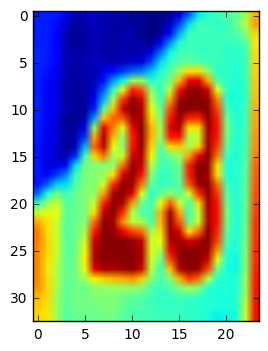

In [9]:
i = 1
print(training_bbox[i])
image_data = ndimage.imread(train_folders[i], flatten=True, mode='RGB').astype(float)
image_data = imresize(image_data, (64, 64))
plt.imshow(image_data)
plt.show()

cropped_image = image_data[int(training_bbox[i][0]*image_data.shape[0]):int(training_bbox[i][1]*image_data.shape[0]),
                           int(training_bbox[i][2]*image_data.shape[1]):int(training_bbox[i][3]*image_data.shape[1])]
plt.imshow(cropped_image)
plt.show()

In [11]:
from PIL import Image
image_size = 64
pixel_depth = 255.0

def load_data(folder):
  """Load the data for a single letter label."""
  image_files = folder
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  num_images = 0
  for image_file in image_files:
    try:
      image_data = ndimage.imread(image_file, flatten=True, mode='RGB').astype(float)
      im = Image.fromarray(image_data)
      im = im.resize((image_size, image_size), Image.ANTIALIAS)
      new_image = np.array(im)
      new_image = (new_image - pixel_depth / 2) / pixel_depth
      dataset[num_images, :, :] = new_image
      num_images = num_images + 1

    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

train_data =  load_data(train_folders)
test_data =  load_data(test_folders)
valid_data =  load_data(valid_folders)

Full dataset tensor: (33402, 64, 64)
Mean: -0.0636493
Standard deviation: 0.20548
Full dataset tensor: (13068, 64, 64)
Mean: -0.0684287
Standard deviation: 0.232184
Full dataset tensor: (10000, 64, 64)
Mean: -0.0581259
Standard deviation: 0.201964


(64, 64)


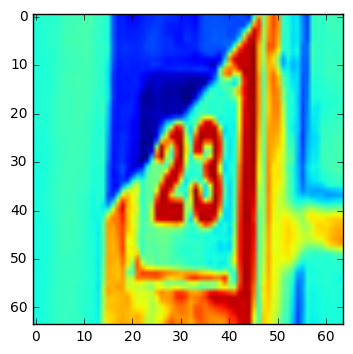

In [12]:
image_data = train_data[1]
plt.figure()
plt.imshow(image_data)
print(image_data.shape)

In [13]:
train_labels = []
num_rows = 73258
with open('digitStruct_train.csv', 'rb') as csvfile:
    x = csv.reader(csvfile, delimiter=',')
    x.next()
    row = x.next()
    label = [int(row[1])]
    
    for _ in range(num_rows - x.line_num):
        next_row = x.next()
        if row[0] == next_row[0]:
            label.append(int(next_row[1]))
        else:
            train_labels.append(label)
            row = next_row
            label = [int(row[1])]
    
    train_labels.append(label)   

test_labels = []
num_rows = 26033
with open('digitStruct_test.csv', 'rb') as csvfile:
    x = csv.reader(csvfile, delimiter=',')
    x.next()
    row = x.next()
    label = [int(row[1])]
    
    for _ in range(num_rows - x.line_num):
        next_row = x.next()
        if row[0] == next_row[0]:
            label.append(int(next_row[1]))
        else:
            test_labels.append(label)
            row = next_row
            label = [int(row[1])]
    
    test_labels.append(label)
    
valid_labels = []
num_rows = 26343
with open('digitStruct_valid.csv', 'rb') as csvfile:
    x = csv.reader(csvfile, delimiter=',')
    x.next()
    row = x.next()
    label = [int(row[1])]
    
    for _ in range(num_rows - x.line_num):
        next_row = x.next()
        if row[0] == next_row[0]:
            label.append(int(next_row[1]))
            
        else:
            valid_labels.append(label)
            row = next_row
            label = [int(row[1])]
    
    valid_labels.append(label)

    
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
valid_labels = np.array(valid_labels)

print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(33402,)
(13068,)
(10000,)


In [14]:
pickle_file = 'svhn.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data,
    'train_labels': train_labels,
    'test_dataset': test_data,
    'test_labels': test_labels,
    'valid_dataset': valid_data,
    'valid_labels': valid_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
pickle_file = 'svhn_bbox.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_bbox': training_bbox
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

# Load libraries and pickled data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from PIL import Image

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
pickle_file = 'svhn.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  del save  # hint to help gc free up memory
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

pickle_file = 'svhn_bbox.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_bbox = save['train_bbox']
  del save  # hint to help gc free up memory
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)
print('Train bounding boxes', len(train_bbox))

Training set (33402, 64, 64) (33402,)
Test set (13068, 64, 64) (13068,)
Valid set (10000, 64, 64) (10000,)
Training set (33402, 64, 64) (33402,)
Test set (13068, 64, 64) (13068,)
Valid set (10000, 64, 64) (10000,)
Train bounding boxes 33402


# SVHN without bounding boxes

In [3]:
image_height = 64
image_length = 64
num_labels = 11
num_channels = 1 # grayscale

def one_hot(l):
    labels = []
    for i in range(5):
        try:
            labels.append((np.arange(num_labels) == l[i]).astype(np.float32))
        except:
            labels.append((np.arange(num_labels) == 10).astype(np.float32))
    return labels
    
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_length, num_channels)).astype(np.float32)
  one_hot_labels = [one_hot(labels[0])]
  for i in range(1, len(labels)):
    one_hot_labels= np.concatenate((one_hot_labels,[one_hot(labels[i])]), axis=0)
  return dataset, one_hot_labels

train_X, train_Y = reformat(train_dataset, train_labels)
del train_dataset
del train_labels

test_X, test_Y = reformat(test_dataset, test_labels)
del test_dataset
del test_labels

valid_X, valid_Y = reformat(valid_dataset, valid_labels)
del valid_dataset
del valid_labels

print('Training set', train_X.shape, train_Y.shape)
print('Test set', test_X.shape, test_Y.shape)
print('Valid set', valid_X.shape, valid_Y.shape)

Training set (33402, 64, 64, 1) (33402, 5, 11)


In [4]:
batch_size = 57
patch_size = 5
depth = 16
num_hidden = 100
num_labels = 11

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5, num_labels))

  tf_valid_dataset = tf.placeholder(
    tf.float32, shape=(50, image_height, image_length, num_channels))
  tf_test_dataset = tf.placeholder(
    tf.float32, shape=(54, image_height, image_length, num_channels))

  # Variables.
  #global_step = tf.Variable(0)
  #learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.96, staircase=True)
    
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  #layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  #layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_length // 4 * depth*2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  classifier1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
  # Model.
  def model(data, keep_prob=False):
    conv =  tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    conv = tf.nn.relu(tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    if keep_prob:
        drop1 = tf.nn.dropout(hidden, keep_prob)
        drop2 = tf.nn.dropout(hidden, keep_prob)
        drop3 = tf.nn.dropout(hidden, keep_prob)
        drop4 = tf.nn.dropout(hidden, keep_prob)
        drop5 = tf.nn.dropout(hidden, keep_prob)
        output1 = tf.matmul(drop1, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(drop2, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(drop3, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(drop4, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(drop5, classifier5_weights) + classifier5_biases
    else:
        output1 = tf.matmul(hidden, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(hidden, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(hidden, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(hidden, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(hidden, classifier5_weights) + classifier5_biases
    return [output1,output2,output3,output4,output5]

  def calc_loss(labels, logits):
     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
         labels=labels, logits=logits))   

  
  # Training computation.
  logits1,logits2,logits3,logits4,logits5 = model(tf_train_dataset) 

  loss = (calc_loss(tf_train_labels[:,0],logits1) + calc_loss(tf_train_labels[:,1],logits2) + calc_loss(
      tf_train_labels[:,2],logits3) + calc_loss(tf_train_labels[:,3],logits4) + calc_loss(
      tf_train_labels[:,4],logits5)) 
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_1, train_2, train_3, train_4, train_5 = tf.nn.softmax(
      logits1), tf.nn.softmax(logits2), tf.nn.softmax(logits3), tf.nn.softmax(logits4), tf.nn.softmax(logits5)
  train_predictions = [train_1, train_2, train_3, train_4, train_5]


In [6]:
num_epochs= 5

def accuracy(predictions, labels):
    result = 0
    for i in range(len(predictions[0])):
        classifiers = [False, False, False, False, False]
        for j in range(5):
            classifiers[j] = np.argmax(predictions[j], 1)[i] == np.argmax(labels[:,j], 1)[i]
        if all(classifiers):
            result+=1
    return 100.0 * (result/float(len(predictions[0])))

def eval_in_batches(dataset, placeholder, predictor):
    prediction_list = [[], [], [], [], []]
    total_batch = int(len(dataset) // batch_size) 
    for step in range(total_batch):
        offset = (step * batch_size) 
        batch_data = dataset[offset:(offset + batch_size), :, :, :]
        feed_dict = {placeholder : batch_data}
        batch = session.run(
          predictor, feed_dict=feed_dict)
        for i in range(len(batch)):
            for j in range(len(batch[0])):
                prediction_list[i].append(batch[i][j])
    return np.array(prediction_list)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  total_batch = int(len(train_X) // batch_size)  
  for epoch in range(num_epochs):
    avg_loss = 0 
    for i in range(total_batch):
        offset = (i * batch_size) % (train_Y.shape[0] - batch_size)
        batch_data = train_X[offset:(offset + batch_size), :, :, :]
        batch_labels = train_Y[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_predictions],feed_dict=feed_dict)
        avg_loss += (l/total_batch)
        if i%(500) == 0:
          print('Minibatch loss is ', l)
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))  
    print('Average loss at epoch %d: %f' % (epoch+1, avg_loss))

Initialized
Minibatch loss is  13.6208
Minibatch accuracy: 0.0%
Minibatch loss is  5.1291
Minibatch accuracy: 3.5%
Average loss at epoch 1: 5.615151
Minibatch loss is  5.14404
Minibatch accuracy: 3.5%
Minibatch loss is  4.4342
Minibatch accuracy: 15.8%
Average loss at epoch 2: 4.990241
Minibatch loss is  4.07983
Minibatch accuracy: 14.0%
Minibatch loss is  3.81831
Minibatch accuracy: 31.6%
Average loss at epoch 3: 4.233290
Minibatch loss is  3.4757
Minibatch accuracy: 31.6%
Minibatch loss is  3.36222
Minibatch accuracy: 40.4%
Average loss at epoch 4: 3.808381
Minibatch loss is  3.13211
Minibatch accuracy: 31.6%
Minibatch loss is  3.21206
Minibatch accuracy: 43.9%
Average loss at epoch 5: 3.532219


In [4]:
batch_size = 57
patch_size = 5
depth = 16
num_hidden = 100
num_labels = 11

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5, num_labels))

  tf_valid_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))
  tf_test_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))

  # Variables.
  #global_step = tf.Variable(0)
  #learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.96, staircase=True)
    
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  #layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  #layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_length // 4 * depth*2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  classifier1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
  # Model.
  def model(data, keep_prob=False):
    conv =  tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    conv = tf.nn.relu(tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    if keep_prob:
        drop1 = tf.nn.dropout(hidden, keep_prob)
        drop2 = tf.nn.dropout(hidden, keep_prob)
        drop3 = tf.nn.dropout(hidden, keep_prob)
        drop4 = tf.nn.dropout(hidden, keep_prob)
        drop5 = tf.nn.dropout(hidden, keep_prob)
        output1 = tf.matmul(drop1, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(drop2, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(drop3, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(drop4, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(drop5, classifier5_weights) + classifier5_biases
    else:
        output1 = tf.matmul(hidden, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(hidden, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(hidden, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(hidden, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(hidden, classifier5_weights) + classifier5_biases
    return [output1,output2,output3,output4,output5]

  def calc_loss(labels, logits):
     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
         labels=labels, logits=logits))   

  
  # Training computation.
  logits1,logits2,logits3,logits4,logits5 = model(tf_train_dataset) 

  loss = (calc_loss(tf_train_labels[:,0],logits1) + calc_loss(tf_train_labels[:,1],logits2) + calc_loss(
      tf_train_labels[:,2],logits3) + calc_loss(tf_train_labels[:,3],logits4) + calc_loss(
      tf_train_labels[:,4],logits5)) 
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_1, train_2, train_3, train_4, train_5 = tf.nn.softmax(
      logits1), tf.nn.softmax(logits2), tf.nn.softmax(logits3), tf.nn.softmax(logits4), tf.nn.softmax(logits5)
  train_predictions = [train_1, train_2, train_3, train_4, train_5]
    
  v1, v2, v3, v4, v5 = model(tf_valid_dataset)
  valid_1, valid_2, valid_3, valid_4, valid_5 = tf.nn.softmax(
      v1), tf.nn.softmax(v2), tf.nn.softmax(v3), tf.nn.softmax(v4), tf.nn.softmax(v5)
  valid_predictions = [valid_1, valid_2, valid_3, valid_4, valid_5]

  t1, t2, t3, t4, t5 = model(tf_test_dataset)
  test_1, test_2, test_3, test_4, test_5 = tf.nn.softmax(
      t1), tf.nn.softmax(t2), tf.nn.softmax(t3), tf.nn.softmax(t4), tf.nn.softmax(t5)
  test_predictions = [test_1, test_2, test_3, test_4, test_5]

In [9]:
num_epochs= 5

def accuracy(predictions, labels):
    result = 0
    for i in range(len(predictions[0])):
        classifiers = [False, False, False, False, False]
        for j in range(5):
            classifiers[j] = np.argmax(predictions[j], 1)[i] == np.argmax(labels[:,j], 1)[i]
        if all(classifiers):
            result+=1
    return 100.0 * (result/float(len(predictions[0])))

def eval_in_batches(dataset, placeholder, predictor):
    prediction_list = [[], [], [], [], []]
    total_batch = int(len(dataset) // batch_size) 
    for step in range(total_batch):
        offset = (step * batch_size) 
        batch_data = dataset[offset:(offset + batch_size), :, :, :]
        feed_dict = {placeholder : batch_data}
        batch = session.run(
          predictor, feed_dict=feed_dict)
        for i in range(len(batch)):
            for j in range(len(batch[0])):
                prediction_list[i].append(batch[i][j])
    return np.array(prediction_list)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  total_batch = int(len(train_X) // batch_size)  
  for epoch in range(num_epochs):
    avg_loss = 0 
    for i in range(total_batch):
        offset = (i * batch_size) % (train_Y.shape[0] - batch_size)
        batch_data = train_X[offset:(offset + batch_size), :, :, :]
        batch_labels = train_Y[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_predictions],feed_dict=feed_dict)
        avg_loss += (l/total_batch)
        if i%(500) == 0:
          print('Minibatch loss is ', l)
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))  
    print('Average loss at epoch %d: %f' % (epoch+1, avg_loss))
    print('Validation accuracy: %.1f%%' % accuracy(
        eval_in_batches(valid_X, tf_valid_dataset, valid_predictions), valid_Y))
    
  print('Test accuracy: %.1f%%' % accuracy(
      eval_in_batches(test_X, tf_test_dataset, test_predictions), test_Y))

Initialized
Minibatch loss is  14.0547
Minibatch accuracy: 0.0%
Minibatch loss is  4.97064
Minibatch accuracy: 7.0%
Average loss at epoch 1: 5.532384
Validation accuracy: 2.2%
Minibatch loss is  4.89492
Minibatch accuracy: 7.0%
Minibatch loss is  4.10651
Minibatch accuracy: 24.6%
Average loss at epoch 2: 4.681357
Validation accuracy: 6.8%
Minibatch loss is  3.82375
Minibatch accuracy: 22.8%
Minibatch loss is  3.48418
Minibatch accuracy: 36.8%
Average loss at epoch 3: 4.035820
Validation accuracy: 8.6%
Minibatch loss is  3.26421
Minibatch accuracy: 33.3%
Minibatch loss is  3.08062
Minibatch accuracy: 42.1%
Average loss at epoch 4: 3.681206
Validation accuracy: 9.5%
Minibatch loss is  2.9422
Minibatch accuracy: 38.6%
Minibatch loss is  2.90551
Minibatch accuracy: 42.1%
Average loss at epoch 5: 3.439612
Validation accuracy: 9.5%
Test accuracy: 19.9%


# Bounding box for localization

In [4]:
batch_size = 57
patch_size = 5
depth = 16
num_hidden = 100
num_labels = 11
image_size = 54
num_channels =1

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5, num_labels))


  # Variables.
  #global_step = tf.Variable(0)
  #learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.96, staircase=True)
    
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  #layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  #layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth*2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [6272, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  classifier1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
  # Model.
  def model(data, keep_prob=False):
    conv =  tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    conv = tf.nn.relu(tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME'))
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    if keep_prob:
        drop1 = tf.nn.dropout(hidden, keep_prob)
        drop2 = tf.nn.dropout(hidden, keep_prob)
        drop3 = tf.nn.dropout(hidden, keep_prob)
        drop4 = tf.nn.dropout(hidden, keep_prob)
        drop5 = tf.nn.dropout(hidden, keep_prob)
        output1 = tf.matmul(drop1, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(drop2, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(drop3, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(drop4, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(drop5, classifier5_weights) + classifier5_biases
    else:
        output1 = tf.matmul(hidden, classifier1_weights) + classifier1_biases
        output2 = tf.matmul(hidden, classifier2_weights) + classifier2_biases
        output3 = tf.matmul(hidden, classifier3_weights) + classifier3_biases
        output4 = tf.matmul(hidden, classifier4_weights) + classifier4_biases
        output5 = tf.matmul(hidden, classifier5_weights) + classifier5_biases
    return [output1,output2,output3,output4,output5]

  def calc_loss(labels, logits):
     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
         labels=labels, logits=logits))   

  
  # Training computation.
  logits1,logits2,logits3,logits4,logits5 = model(tf_train_dataset) 

  loss = (calc_loss(tf_train_labels[:,0],logits1) + calc_loss(tf_train_labels[:,1],logits2) + calc_loss(
      tf_train_labels[:,2],logits3) + calc_loss(tf_train_labels[:,3],logits4) + calc_loss(
      tf_train_labels[:,4],logits5)) 
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_1, train_2, train_3, train_4, train_5 = tf.nn.softmax(
      logits1), tf.nn.softmax(logits2), tf.nn.softmax(logits3), tf.nn.softmax(logits4), tf.nn.softmax(logits5)
  train_predictions = [train_1, train_2, train_3, train_4, train_5]

In [10]:
num_epochs= 5

image_height = 54
image_length = 54
num_labels = 11
num_channels = 1 # grayscale

def one_hot(l):
    labels = []
    for i in range(5):
        try:
            labels.append((np.arange(num_labels) == l[i]).astype(np.float32))
        except:
            labels.append((np.arange(num_labels) == 10).astype(np.float32))
    return labels
    
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_height, image_length, num_channels)).astype(np.float32)
    one_hot_labels = [one_hot(labels[0])]
    for i in range(1, len(labels)):
        one_hot_labels= np.concatenate((one_hot_labels,[one_hot(labels[i])]), axis=0)
    return dataset, one_hot_labels

def accuracy(predictions, labels):
    result = 0
    for i in range(len(predictions[0])):
        classifiers = [False, False, False, False, False]
        for j in range(5):
            classifiers[j] = np.argmax(predictions[j], 1)[i] == np.argmax(labels[:,j], 1)[i]
        if all(classifiers):
            result+=1
    return 100.0 * (result/float(len(predictions[0])))

def bounding_box_batch(i):
    offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    batch_bbox = train_bbox[offset:(offset + batch_size)]
    
    crop_list = []
    for bbox, image in zip(batch_bbox, batch_data):
        crop_list.append(image[int(bbox[0]*image.shape[0]):int(bbox[1]*image.shape[0]),
                               int(bbox[2]*image.shape[1]):int(bbox[3]*image.shape[1])])
    
    for i in range(len(crop_list)):
        im = Image.fromarray(crop_list[i])
        im = im.resize((54, 54), Image.ANTIALIAS)
        np.array(im)
        crop_list[i] = np.array(im)
        
    #print(type(crop_list[0]))
    batch_crop = np.array(crop_list)
        
    train_X, train_Y = reformat(batch_crop, batch_labels)
    return train_X, train_Y

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  total_batch = int(len(train_dataset) // batch_size)  
  for epoch in range(num_epochs):
    avg_loss = 0 
    for i in range(total_batch):
        batch_data, batch_labels = bounding_box_batch(i)
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_predictions],feed_dict=feed_dict)
        avg_loss += l/total_batch
        if i%(100) == 0:
          print('Minibatch loss is ', l)
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))  
    print('Average loss at epoch %d: %f' % (epoch+1, avg_loss))

Initialized
Minibatch loss is  17.4568
Minibatch accuracy: 0.0%
Minibatch loss is  5.52724
Minibatch accuracy: 0.0%
Minibatch loss is  5.65437
Minibatch accuracy: 0.0%
Minibatch loss is  4.98035
Minibatch accuracy: 7.0%
Minibatch loss is  5.53779
Minibatch accuracy: 3.5%
Minibatch loss is  4.81152
Minibatch accuracy: 5.3%
Average loss at epoch 1: 5.400871
Minibatch loss is  4.70504
Minibatch accuracy: 5.3%
Minibatch loss is  4.5995
Minibatch accuracy: 8.8%
Minibatch loss is  4.38477
Minibatch accuracy: 8.8%
Minibatch loss is  3.35731
Minibatch accuracy: 28.1%
Minibatch loss is  4.57673
Minibatch accuracy: 19.3%
Minibatch loss is  3.48721
Minibatch accuracy: 31.6%
Average loss at epoch 2: 4.285263
Minibatch loss is  3.21309
Minibatch accuracy: 31.6%
Minibatch loss is  3.78237
Minibatch accuracy: 26.3%
Minibatch loss is  3.51627
Minibatch accuracy: 33.3%
Minibatch loss is  2.58401
Minibatch accuracy: 49.1%
Minibatch loss is  3.96838
Minibatch accuracy: 29.8%
Minibatch loss is  2.90942
Mi